### 1. Imports

In [1]:
import numpy as np
import pandas as pd
import os
import time
import torch
import torch.nn as nn
import sys
import math
import random

import torchvision
from torchvision import models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torch.utils.data import random_split
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

### 2. Filepaths

In [2]:
AAF_TRAIN_PATH = 'drive/My Drive/AWL Internship/MixMatch/AAF_Gender_Classification/AAF_train_MixMatch.xlsx'
AAF_TEST_PATH = 'drive/My Drive/AWL Internship/MixMatch/AAF_Gender_Classification/AAF_test_MixMatch.xlsx'
#!unzip -q 'drive/My Drive/AWL Internship/AAF Dataset/extracted_original-20'
AAF_IMAGE_PATH = 'extracted_original-20'

### 3. Arguments/Hyperparameters

In [3]:
CUDA = 0
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
NUM_EPOCHS = 15
BATCH_SIZE = 64
NUM_LABELLED = 1000	#No of labelled examples to be used in MixMatch
DEVICE = torch.device("cuda:%d" % CUDA)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla P100-PCIE-16GB


### 4. AAF Dataset Class

In [4]:
class AAF_Dataset(Dataset):
	''' Custom Dataset for loading AAF Dataset images'''

	def __init__(self, csv_path, img_dir, transform):
		
		df = pd.read_excel(csv_path)
		self.img_dir = img_dir
		self.transform = transform
		self.csv_path = csv_path
		self.gender = df['Gender'].values
		self.filename = df['Image'].values
	
	#def preprocess(self):
	''' Any further preprocessing required in the data
		can be performed here'''


	def __getitem__(self, index):

		img = Image.open(os.path.join(self.img_dir,
									self.filename[index]))
		img = self.transform(img)
		y_true = self.gender[index]
		y_true = torch.tensor(y_true, dtype=torch.float32)
		
		return img, y_true

	def __len__(self):
		return self.gender.shape[0]

### 5. Transformation

In [5]:
custom_transform = transforms.Compose([transforms.Resize((96,96)),
							transforms.ToTensor()])	

### 6. Sample batch for visualization

Batch shape (images):  torch.Size([4, 3, 96, 96])
Batch shape (labels):  torch.Size([4])


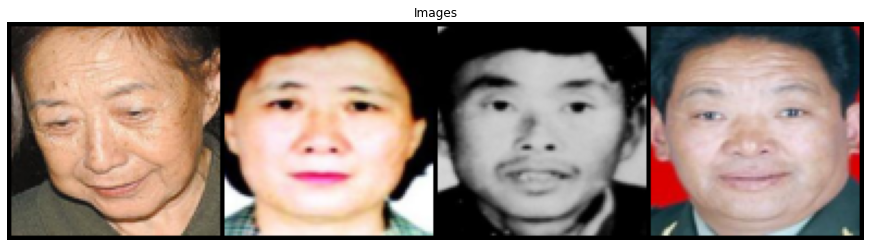

Labels:  tensor([0., 0., 1., 1.])


In [9]:
sample_batch_size = 4
sample_dataset = AAF_Dataset(csv_path=AAF_TRAIN_PATH, img_dir=AAF_IMAGE_PATH, transform=custom_transform)
sample_loader = DataLoader(dataset=sample_dataset, batch_size=sample_batch_size, shuffle=True)

dataiter = iter(sample_loader)
images, labels = dataiter.next()

print("Batch shape (images): ",images.shape)
print("Batch shape (labels): ", labels.shape)
#print(y_true.shape)

#print(images[0])
# print(images[0].shape)
# print(labels[0].item())
#print(y_true[0])

def imshow(img, title):
    '''Function imshow: Helper function to display an image'''
    plt.figure(figsize=(sample_batch_size * 4, 4))
    plt.axis('off')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(title)
    plt.show()

def show_batch_images(dataloader):
    '''Function show_batch_images: Helper function to display images with their true ages'''
    images, labels = next(iter(dataloader))
    
    img = torchvision.utils.make_grid(images)
    imshow(img, title = 'Images')
    print("Labels: ",labels)
    
    return images, labels
images, labels = show_batch_images(sample_loader)

### 7. Datasets and Dataloaders

In [10]:
AAF_train = AAF_Dataset(csv_path=AAF_TRAIN_PATH, img_dir=AAF_IMAGE_PATH, transform=custom_transform)

AAF_train_labelled, AAF_train_unlabelled = random_split(AAF_train, [NUM_LABELLED, len(AAF_train) - NUM_LABELLED])

trainloader_labelled = DataLoader(AAF_train_labelled, batch_size=BATCH_SIZE, shuffle=True)
trainloader_unlabelled = DataLoader(AAF_train_unlabelled, batch_size=BATCH_SIZE, shuffle=True)

AAF_test = AAF_Dataset(csv_path=AAF_TEST_PATH, img_dir=AAF_IMAGE_PATH, transform=custom_transform)

testloader = DataLoader(AAF_test, batch_size= BATCH_SIZE, shuffle=False)

print("Labelled examples: " + str(len(AAF_train_labelled)) + "\nUnlabelled examples: " 
      + str(len(AAF_train_unlabelled)) + "\nTest examples: " + str(len(AAF_test)))

# dataiter = iter(trainloader_labelled)
# images, labels = dataiter.next()
# print(labels[:])
# print(len(AAF_train_labelled), len(AAF_train_unlabelled))

Labelled examples: 1000
Unlabelled examples: 8991
Test examples: 3331


### 8. MixMatch Utilities

In [11]:
def augment_image(batch_img, K = 2):
	'''Function augment_image:
		Input: PIL Image/Torch Tensor
		Output: K number of augmented images'''
	
	batch_augment_images = []
	for i in range(batch_img.shape[0]):
		img = batch_img[i]
		img = TF.to_pil_image(img.cpu())
		img_1 = TF.to_tensor(TF.adjust_brightness(img, np.random.uniform(0.5, 1.5)))
		img_2 = TF.to_tensor(TF.adjust_contrast(img, np.random.uniform(0.5, 1.5)))
		img_3 = TF.to_tensor(TF.adjust_saturation(img, np.random.uniform(0.5, 1.5)))
		
		img_4 = TF.to_tensor(TF.hflip(img))
		img_5 = TF.to_tensor(TF.rotate(img, angle=np.random.uniform(-10,10)))

		img_6 = TF.to_tensor(TF.to_grayscale(img, num_output_channels=3))
		img_7 = TF.to_tensor(TF.adjust_gamma(img, np.random.uniform(0.5, 1.5)))

		random_numbers = random.sample(range(1, 8), K)
		img_dict = {'1': img_1, '2': img_2, '3': img_3, '4': img_4, '5': img_5, '6': img_6, '7': img_7}

		augment_images = []
		for i in random_numbers:
			augment_images.append(img_dict[str(i)])
		#augment_images = torch.FloatTensor(augment_images)
		batch_augment_images.append(augment_images)
	#batch_augment_images = torch.tensor(batch_augment_images)
	return batch_augment_images

def label_guessing(model, augment_images, device):
	''' Function label_guessing
		Input: Classifier model, K augmentations of the unlabelled data
		Ouput: Calls augment_image function, makes predictions for the K augmentations and averages them to get the guessed
				labels for unlabelled data.
		'''
	predictions = []
	# augment_images = np.array(augment_images)
	# print(np.shape(augment_images))
	for i in range(0,len(augment_images)):
		#print(np.shape(augment_images[i]))
		#augment_images[i] = augment_images[i].unsqueeze(0)
		#print(len(augment_images))
		img = torch.stack(augment_images[i], dim=0)
		#img = img.unsqueeze(0)
		img = img.to(device)
		logits = model(img)
		probas = nn.functional.softmax(logits, dim=1)
		#y_pred = torch.argmax(probas, dim=1)
		predictions.append(probas)
	predictions = torch.stack(predictions,dim=0)
	q_hat = torch.mean(predictions, dim=1)

	return q_hat

def sharpen(p, T=0.5):
	p_sharp = torch.pow(p, 1/T)/(torch.sum(torch.pow(p, 1/T), dim=0))
	return p_sharp

def mixup(x1,y1,x2,y2,alpha=0.75):
    l = np.random.beta(alpha,alpha)
    #print(l)
    l = max(l,1-l)
    x = l * x1 + (1-l) * x2
    y = l* y1 + (1-l) * y2
    return x,y

### 9. MixMatch Dataset Class

In [12]:
class MixMatch_Dataset(Dataset):
	'''Supply a batch of labelled and unlabelled data, X and U.'''
	
	def __init__(self, Labelled_data, Unlabelled_data):
		self.Labelled_data = Labelled_data
		self.Unlabelled_data = Unlabelled_data
  
	def __getitem__(self, index):
		
		size_labelled = len(self.Labelled_data)
		size_unlabelled = len(self.Unlabelled_data)
		#print(size_labelled, size_unlabelled)
		if(index < size_labelled):
			l_index = index
			#print(1)
		else:
			l_index = int(index*len(self.Labelled_data)/len(self.Unlabelled_data))
			#print(0)
		if(index < size_unlabelled):
			u_index = index
		else:
			u_index = index - size_unlabelled
		#print(l_index)
		x = self.Labelled_data[l_index][0]
		y = self.Labelled_data[l_index][1]
		u = self.Unlabelled_data[u_index][0]

		return x, y, u
	
	def __len__(self):
		return max(len(self.Labelled_data), len(self.Unlabelled_data))

MixMatch_dataset = MixMatch_Dataset(Labelled_data=AAF_train_labelled, Unlabelled_data=AAF_train_unlabelled)
MixMatch_loader = DataLoader(MixMatch_dataset, batch_size=BATCH_SIZE, shuffle=True)

### 10. Loss Functions

In [13]:
cross_entropy = nn.CrossEntropyLoss(reduction='sum')
l2_loss = nn.MSELoss(reduction='sum')

### 11. Wide-Resnet Model

In [19]:
model_1 = models.wide_resnet50_2(pretrained=True)
model_1.to(DEVICE)
print(summary(model_1, (3, 96, 96)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5          [-1, 128, 24, 24]           8,192
       BatchNorm2d-6          [-1, 128, 24, 24]             256
              ReLU-7          [-1, 128, 24, 24]               0
            Conv2d-8          [-1, 128, 24, 24]         147,456
       BatchNorm2d-9          [-1, 128, 24, 24]             256
             ReLU-10          [-1, 128, 24, 24]               0
           Conv2d-11          [-1, 256, 24, 24]          32,768
      BatchNorm2d-12          [-1, 256, 24, 24]             512
           Conv2d-13          [-1, 256, 24, 24]          16,384
      BatchNorm2d-14          [-1, 256,

### 12. Gender Classification Model

In [20]:
class Gender_Classifier(nn.Module):
        def __init__(self):
            super(Gender_Classifier, self).__init__()

            self.fc1 = nn.Linear(1000, 100)
            self.fc2 = nn.Linear(100, 10)
            self.fc3 = nn.Linear(10,2)

        def forward(self, x):
            x = self.fc1(x)
            x = self.fc2(x)
            logits = self.fc3(x)
            return logits

### 13. Stack classifier onto the Wide-Resnet architecture

In [21]:
model_2 = Gender_Classifier()
model = nn.Sequential(model_1, model_2)
model.to(DEVICE)
print(summary(model, (3,96,96)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5          [-1, 128, 24, 24]           8,192
       BatchNorm2d-6          [-1, 128, 24, 24]             256
              ReLU-7          [-1, 128, 24, 24]               0
            Conv2d-8          [-1, 128, 24, 24]         147,456
       BatchNorm2d-9          [-1, 128, 24, 24]             256
             ReLU-10          [-1, 128, 24, 24]               0
           Conv2d-11          [-1, 256, 24, 24]          32,768
      BatchNorm2d-12          [-1, 256, 24, 24]             512
           Conv2d-13          [-1, 256, 24, 24]          16,384
      BatchNorm2d-14          [-1, 256,

### 14. Optimizer

In [22]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

### 15. Tensorboard

In [ ]:
writer = SummaryWriter()
dataiter = iter(trainloader_labelled)
images, labels = dataiter.next()
grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid, 0)
writer.add_graph(model, images.to(DEVICE))
writer.close()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs --host=127.0.0.1

### 16. Model training

In [23]:
start_time = time.time()
num_batches = 0
#costs = []

for epoch in range(NUM_EPOCHS):

	model.train()
	for batch_idx, (x, y, u) in enumerate(MixMatch_loader):
		x = x.to(DEVICE)
		y = y.to(DEVICE)
		u = u.to(DEVICE)
		num_batches += 1

		augment_images = augment_image(u, K=4)
		q_hat = label_guessing(model, augment_images, device=DEVICE)
		q = torch.argmax(sharpen(q_hat), dim = 1)
		
		# y_pred = model(x)
  
		# q_pred_logits = model(u)
		# q_pred_probas = nn.functional.softmax(q_pred_logits, dim=1)
		# q_pred = torch.argmax(q_pred_probas, dim=1)
		
		# cost_labelled = cross_entropy(y_pred, y.long())
		# cost_unlabelled = l2_loss(q_pred, q.float())
		
		wx = torch.cat([x,u])
		wy = torch.cat([y,q])

		idx = torch.randperm(wx.shape[0])

		x_mix, y_mix = mixup(x, y, wx[idx[:int(len(idx)/2)]], wy[idx[:int(len(idx)/2)]])
		u_mix, q_mix = mixup(u, q, wx[idx[int(len(idx)/2):]], wy[idx[int(len(idx)/2):]])

		y_mix_pred = model(x_mix)
		q_mix_pred_logits = model(u_mix)
		q_mix_pred_probas = nn.functional.softmax(q_mix_pred_logits, dim=1)
		q_mix_pred = torch.argmax(q_mix_pred_probas, dim=1)
		
		cost_labelled = cross_entropy(y_mix_pred, y_mix.long())
		cost_unlabelled = l2_loss(q_mix_pred, q_mix)

		if(num_batches < 1000):
			ramp = num_batches/1000
		else:
			ramp = 1
		loss = cost_labelled + ramp*cost_unlabelled

		optimizer.zero_grad()

		loss.backward()

		#costs.append(loss)
		optimizer.step()
		if(batch_idx % 25 == 0):
			# writer.add_scalar('Total Loss', loss, epoch*len(MixMatch_dataset) + batch_idx)
			# writer.add_scalar('Labelled Loss', cost_labelled, epoch*len(MixMatch_dataset) + batch_idx)
			# writer.add_scalar('Unlabelled Loss', cost_unlabelled, epoch*len(MixMatch_dataset) + batch_idx)
			# writer.add_scalars('Labelled and Unlabelled Loss', {'cost_labelled': cost_labelled,
			# 													'cost_unlabelled': cost_unlabelled}, 
			# 														  epoch*len(MixMatch_dataset) + batch_idx)
			
			s = ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f | Labelled loss: %.4f | Unlabelled loss: %.4f\n'
				% (epoch, NUM_EPOCHS, batch_idx,
					len(MixMatch_dataset)//BATCH_SIZE, loss, cost_labelled, cost_unlabelled))
			with open('drive/My Drive/AWL Internship/MixMatch/Training Logs/train_log_'+str(NUM_LABELLED) + '.txt', 'a') as writefile:
				writefile.write(s)
	
	s = 'Time elapsed: %.2f min\n' % ((time.time() - start_time)/60)
	with open('drive/My Drive/AWL Internship/MixMatch/Training Logs/train_log_'+str(NUM_LABELLED) + '.txt', 'a') as writefile:
		writefile.write(s)
	model.eval()
	y_true = []
	y_pred = []
	with torch.set_grad_enabled(False):
		for batch_idx, (img, label) in enumerate(testloader):
			img = img.to(DEVICE)
			label = label.to(DEVICE)

			logits = model(img)
			probas = nn.functional.softmax(logits, dim=1)
			pred = torch.argmax(probas, dim=1)
			y_true.extend(label.cpu().numpy())
			y_pred.extend(pred.cpu().numpy())
	acc = accuracy_score(y_true, y_pred)
	f1 = f1_score(y_true, y_pred)
	# if(batch_idx % 50 == 0):
		# writer.add_scalar('F1-score', f1, epoch)
		# writer.add_scalar('Accuracy', acc, epoch)
	with open('drive/My Drive/AWL Internship/MixMatch/Training Logs/train_log_'+str(NUM_LABELLED) + '.txt', 'a') as writefile:
		writefile.write("Accuracy: " + str(acc) + "\n")
		writefile.write("F1_score: " + str(f1) + "\n")

RuntimeError: ignored

In [ ]:
model.eval()
y_true = []
y_pred = []
with torch.set_grad_enabled(False):
    correct_results = 0
    for batch_idx, (img, label) in enumerate(testloader):
        img = img.to(DEVICE)
        label = label.to(DEVICE)

        logits = model(img)
        probas = nn.functional.softmax(logits, dim=1)
        pred = torch.argmax(probas, dim=1)
        y_true.extend(label.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())
print(accuracy_score(y_true, y_pred))
print(f1_score(y_true, y_pred))

0.6733713599519664
0.429769392033543
